In [ ]:
import random
import pandas as pd
import networkx as nx
from faker import Faker

# -------------------------
# Configuration
# -------------------------
NUM_CITIES = 50
NUM_HOTELS = 300
NUM_RESTAURANTS = 300
NUM_USERS = 500
NUM_FLIGHTS = 500

fake = Faker()

# -------------------------
# Data Generation Functions
# -------------------------
def generate_cities(num=NUM_CITIES):
    cities = []
    for _ in range(num):
        cities.append({
            'city_id': fake.uuid4(),
            'city_name': fake.city()
        })
    return pd.DataFrame(cities)

def generate_hotels(cities_df, num=NUM_HOTELS):
    hotels = []
    # Ensure each city has at least one hotel
    city_ids = cities_df['city_id'].tolist()
    for cid in city_ids:
        hotels.append({
            'hotel_id': fake.uuid4(),
            'hotel_name': fake.company(),
            'city_id': cid
        })
    # Add extra random hotels
    for _ in range(num - len(city_ids)):
        cid = random.choice(city_ids)
        hotels.append({
            'hotel_id': fake.uuid4(),
            'hotel_name': fake.company(),
            'city_id': cid
        })
    return pd.DataFrame(hotels)

def generate_restaurants(cities_df, num=NUM_RESTAURANTS):
    restaurants = []
    # Ensure each city has at least one restaurant
    city_ids = cities_df['city_id'].tolist()
    for cid in city_ids:
        restaurants.append({
            'restaurant_id': fake.uuid4(),
            'restaurant_name': fake.company(),
            'city_id': cid
        })
    # Add extra random restaurants
    for _ in range(num - len(city_ids)):
        cid = random.choice(city_ids)
        restaurants.append({
            'restaurant_id': fake.uuid4(),
            'restaurant_name': fake.company(),
            'city_id': cid
        })
    return pd.DataFrame(restaurants)

def generate_users(cities_df, num=NUM_USERS):
    users = []
    city_ids = cities_df['city_id'].tolist()
    for _ in range(num):
        visited = random.choice(city_ids)
        # "wants_to_visit" may be different
        wants = random.choice(city_ids)
        users.append({
            'user_id': fake.uuid4(),
            'name': fake.name(),
            'visited_city_id': visited,
            'wants_to_visit_city_id': wants
        })
    return pd.DataFrame(users)

def generate_flights(users_df, cities_df, num=NUM_FLIGHTS):
    flights = []
    user_ids = users_df['user_id'].tolist()
    city_ids = cities_df['city_id'].tolist()
    for _ in range(num):
        flights.append({
            'flight_id': fake.uuid4(),
            'user_id': random.choice(user_ids),
            'city_id': random.choice(city_ids)  # destination city
        })
    return pd.DataFrame(flights)

def generate_preferences(users_df):
    preferences = []
    for _, user in users_df.iterrows():
        num_prefs = random.randint(1, 3)
        for _ in range(num_prefs):
            preferences.append({
                'preference_id': fake.uuid4(),
                'user_id': user['user_id'],
                'preference_detail': fake.word()
            })
    return pd.DataFrame(preferences)

# -------------------------
# Graph Building with NetworkX
# -------------------------
def build_graph(cities_df, hotels_df, restaurants_df, users_df, flights_df, prefs_df):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes with labels as node attributes
    # Cities
    for _, row in cities_df.iterrows():
        G.add_node(row['city_id'], label="City", name=row['city_name'])
    
    # Hotels
    for _, row in hotels_df.iterrows():
        G.add_node(row['hotel_id'], label="Hotel", name=row['hotel_name'], city_id=row['city_id'])
    
    # Restaurants
    for _, row in restaurants_df.iterrows():
        G.add_node(row['restaurant_id'], label="Restaurant", name=row['restaurant_name'], city_id=row['city_id'])
    
    # Users
    for _, row in users_df.iterrows():
        G.add_node(row['user_id'], label="User", name=row['name'], visited_city_id=row['visited_city_id'], 
                   wants_to_visit_city_id=row['wants_to_visit_city_id'])
    
    # Flights
    for _, row in flights_df.iterrows():
        G.add_node(row['flight_id'], label="Flight", user_id=row['user_id'], city_id=row['city_id'])
    
    # Preferences
    for _, row in prefs_df.iterrows():
        G.add_node(row['preference_id'], label="Preference", preference_detail=row['preference_detail'], user_id=row['user_id'])
    
    # -------------------------
    # Create Relationships (Edges)
    # -------------------------
    # User BOOKED_FLIGHT Flight
    for _, row in flights_df.iterrows():
        user_id = row['user_id']
        flight_id = row['flight_id']
        if user_id in G and flight_id in G:
            G.add_edge(user_id, flight_id, relationship="BOOKED_FLIGHT")
    
    # Flight HAS_FLIGHT City (destination)
    for _, row in flights_df.iterrows():
        flight_id = row['flight_id']
        city_id = row['city_id']
        if flight_id in G and city_id in G:
            G.add_edge(flight_id, city_id, relationship="HAS_FLIGHT")
    
    # User VISITED City (using visited_city_id from users)
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        visited_city = row['visited_city_id']
        if user_id in G and visited_city in G:
            G.add_edge(user_id, visited_city, relationship="VISITED")
    
    # User WANTS_TO_VISIT City (using wants_to_visit_city_id)
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        want_city = row['wants_to_visit_city_id']
        if user_id in G and want_city in G:
            G.add_edge(user_id, want_city, relationship="WANTS_TO_VISIT")
    
    # Create lookup dictionaries for hotels and restaurants by city
    hotels_by_city = hotels_df.groupby("city_id")["hotel_id"].apply(list).to_dict()
    restaurants_by_city = restaurants_df.groupby("city_id")["restaurant_id"].apply(list).to_dict()
    
    # User STAYED_AT Hotel and DINED_AT Restaurant (from visited city)
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        visited_city = row['visited_city_id']
        if visited_city in hotels_by_city:
            hotel_id = random.choice(hotels_by_city[visited_city])
            if user_id in G and hotel_id in G:
                G.add_edge(user_id, hotel_id, relationship="STAYED_AT")
        else:
            print(f"No hotel found for user {user_id} in city {visited_city}.")
        if visited_city in restaurants_by_city:
            restaurant_id = random.choice(restaurants_by_city[visited_city])
            if user_id in G and restaurant_id in G:
                G.add_edge(user_id, restaurant_id, relationship="DINED_AT")
        else:
            print(f"No restaurant found for user {user_id} in city {visited_city}.")
    
    # User HAS_PREFERENCE Preference
    for _, row in prefs_df.iterrows():
        user_id = row['user_id']
        pref_id = row['preference_id']
        if user_id in G and pref_id in G:
            G.add_edge(user_id, pref_id, relationship="HAS_PREFERENCE")
    
    return G

# -------------------------
# Main Execution
# -------------------------
def main():
    print("Generating synthetic data...")
    cities_df = generate_cities()
    hotels_df = generate_hotels(cities_df)
    restaurants_df = generate_restaurants(cities_df)
    users_df = generate_users(cities_df)
    flights_df = generate_flights(users_df, cities_df)
    prefs_df = generate_preferences(users_df)
    
    print("Building in-memory graph using NetworkX...")
    G = build_graph(cities_df, hotels_df, restaurants_df, users_df, flights_df, prefs_df)
    
    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    # Optionally, inspect some edges or save the graph for later use.
    # For example, print all edges with relationship attribute:
    for u, v, data in list(G.edges(data=True))[:10]:
        print(f"{u} -[{data['relationship']}]-> {v}")
    
if __name__ == "__main__":
    main()



Generating synthetic data...
Building in-memory graph using NetworkX...
Graph built with 2706 nodes and 4046 edges.
fcb5f2ae-8c84-4f74-a9b5-0d775559e647 -[BOOKED_FLIGHT]-> 7c34d166-309b-48d6-88aa-95ae686a7cd4
fcb5f2ae-8c84-4f74-a9b5-0d775559e647 -[VISITED]-> f8750848-7103-4286-9859-a9003182f838
fcb5f2ae-8c84-4f74-a9b5-0d775559e647 -[WANTS_TO_VISIT]-> 4c7f2108-0943-4e23-bc44-3a753b0e2a64
fcb5f2ae-8c84-4f74-a9b5-0d775559e647 -[STAYED_AT]-> e6924a5e-a470-4a64-9eca-6a55ad1ab524
fcb5f2ae-8c84-4f74-a9b5-0d775559e647 -[DINED_AT]-> d0ae7b28-1e27-4836-8f88-cda60807aeca
fcb5f2ae-8c84-4f74-a9b5-0d775559e647 -[HAS_PREFERENCE]-> 7a4c3244-891a-40a8-b867-c4e6f2ee9b25
fcb5f2ae-8c84-4f74-a9b5-0d775559e647 -[HAS_PREFERENCE]-> dbd5310c-db69-45d9-8566-715a1da28c31
fcb5f2ae-8c84-4f74-a9b5-0d775559e647 -[HAS_PREFERENCE]-> 0d1c7944-3fc7-430d-9ae9-2af0bcb4e004
140d9b12-23ef-4fbc-88a3-ddb5d28207ce -[BOOKED_FLIGHT]-> c71aafeb-ba34-4682-a794-bb1ff3c3724f
140d9b12-23ef-4fbc-88a3-ddb5d28207ce -[VISITED]-> d9a6bb83

Generating synthetic data...
Building in-memory graph using NetworkX...
Graph built with 44145 nodes and 79948 edges.
Visualizing a sample subgraph...


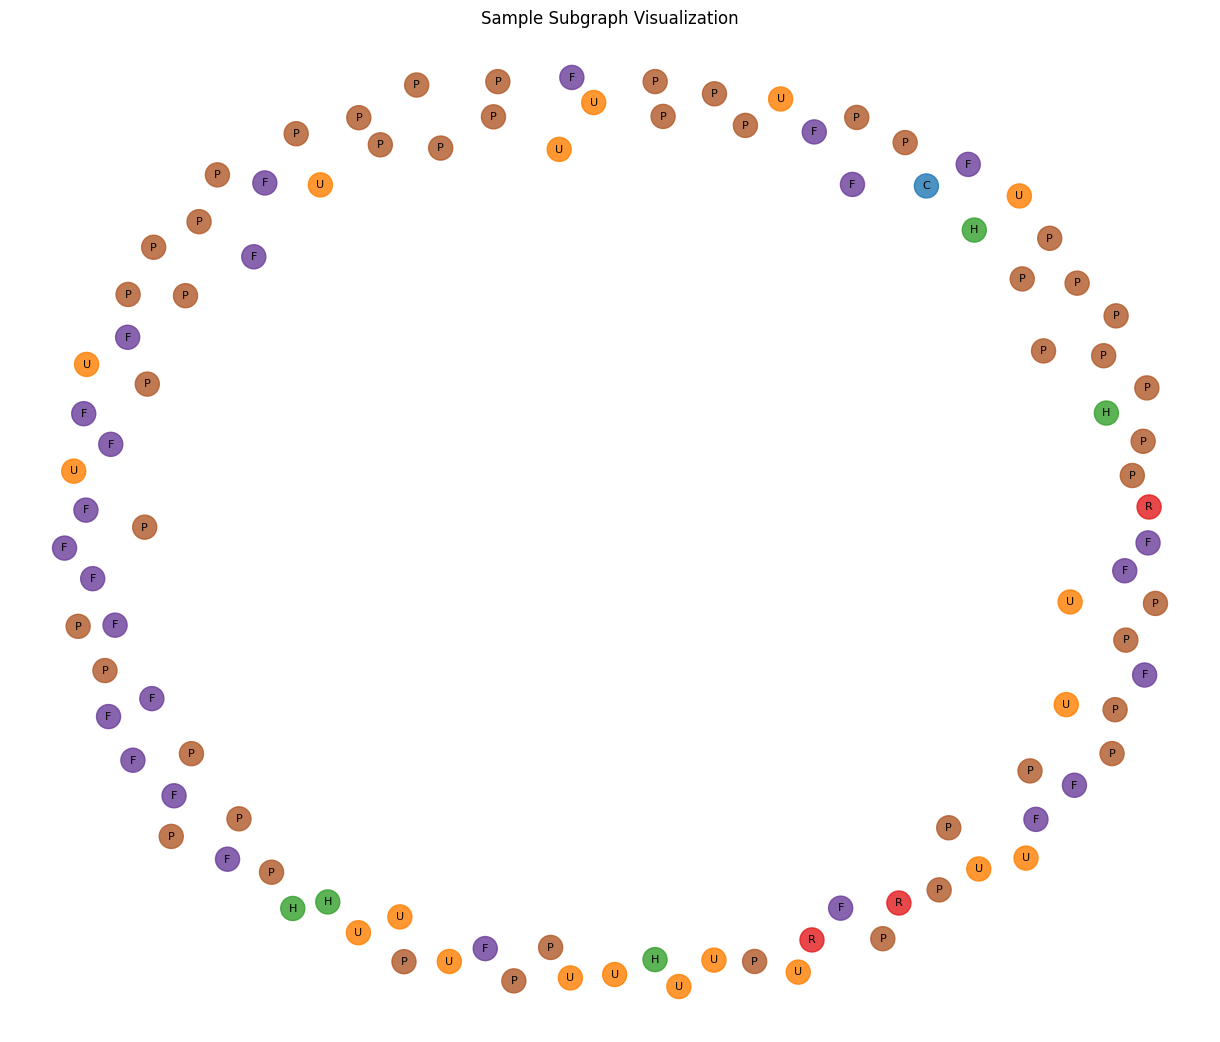

In [22]:
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from faker import Faker

# -------------------------
# Configuration - Scale Up for a Robust RAG System
# -------------------------
NUM_CITIES = 100
NUM_HOTELS = 2000
NUM_RESTAURANTS = 2000
NUM_USERS = 10000
NUM_FLIGHTS = 10000

fake = Faker()

# -------------------------
# Data Generation Functions
# -------------------------
def generate_cities(num=NUM_CITIES):
    cities = []
    for _ in range(num):
        cities.append({
            'city_id': fake.uuid4(),
            'city_name': fake.city()
        })
    return pd.DataFrame(cities)

def generate_hotels(cities_df, num=NUM_HOTELS):
    hotels = []
    city_ids = cities_df['city_id'].tolist()
    for cid in city_ids:
        hotels.append({
            'hotel_id': fake.uuid4(),
            'hotel_name': fake.company(),
            'city_id': cid
        })
    for _ in range(num - len(city_ids)):
        cid = random.choice(city_ids)
        hotels.append({
            'hotel_id': fake.uuid4(),
            'hotel_name': fake.company(),
            'city_id': cid
        })
    return pd.DataFrame(hotels)

def generate_restaurants(cities_df, num=NUM_RESTAURANTS):
    restaurants = []
    city_ids = cities_df['city_id'].tolist()
    for cid in city_ids:
        restaurants.append({
            'restaurant_id': fake.uuid4(),
            'restaurant_name': fake.company(),
            'city_id': cid
        })
    for _ in range(num - len(city_ids)):
        cid = random.choice(city_ids)
        restaurants.append({
            'restaurant_id': fake.uuid4(),
            'restaurant_name': fake.company(),
            'city_id': cid
        })
    return pd.DataFrame(restaurants)

def generate_users(cities_df, num=NUM_USERS):
    users = []
    city_ids = cities_df['city_id'].tolist()
    for _ in range(num):
        visited = random.choice(city_ids)
        wants = random.choice(city_ids)
        users.append({
            'user_id': fake.uuid4(),
            'name': fake.name(),
            'visited_city_id': visited,
            'wants_to_visit_city_id': wants
        })
    return pd.DataFrame(users)

def generate_flights(users_df, cities_df, num=NUM_FLIGHTS):
    flights = []
    user_ids = users_df['user_id'].tolist()
    city_ids = cities_df['city_id'].tolist()
    for _ in range(num):
        flights.append({
            'flight_id': fake.uuid4(),
            'user_id': random.choice(user_ids),
            'city_id': random.choice(city_ids)
        })
    return pd.DataFrame(flights)

def generate_preferences(users_df):
    preferences = []
    for _, user in users_df.iterrows():
        num_prefs = random.randint(1, 3)
        for _ in range(num_prefs):
            preferences.append({
                'preference_id': fake.uuid4(),
                'user_id': user['user_id'],
                'preference_detail': fake.word()
            })
    return pd.DataFrame(preferences)

# -------------------------
# Graph Building with NetworkX
# -------------------------
def build_graph(cities_df, hotels_df, restaurants_df, users_df, flights_df, prefs_df):
    G = nx.DiGraph()
    
    # Cities
    for _, row in cities_df.iterrows():
        G.add_node(row['city_id'], label="City", name=row['city_name'])
    
    # Hotels
    for _, row in hotels_df.iterrows():
        G.add_node(row['hotel_id'], label="Hotel", name=row['hotel_name'], city_id=row['city_id'])
    
    # Restaurants
    for _, row in restaurants_df.iterrows():
        G.add_node(row['restaurant_id'], label="Restaurant", name=row['restaurant_name'], city_id=row['city_id'])
    
    # Users
    for _, row in users_df.iterrows():
        G.add_node(row['user_id'], label="User", name=row['name'], 
                   visited_city_id=row['visited_city_id'], 
                   wants_to_visit_city_id=row['wants_to_visit_city_id'])
    
    # Flights
    for _, row in flights_df.iterrows():
        G.add_node(row['flight_id'], label="Flight", user_id=row['user_id'], city_id=row['city_id'])
    
    # Preferences
    for _, row in prefs_df.iterrows():
        G.add_node(row['preference_id'], label="Preference", 
                   preference_detail=row['preference_detail'], user_id=row['user_id'])
    
    # Create Relationships (Edges)
    for _, row in flights_df.iterrows():
        user_id = row['user_id']
        flight_id = row['flight_id']
        if user_id in G and flight_id in G:
            G.add_edge(user_id, flight_id, relationship="BOOKED_FLIGHT")
    
    for _, row in flights_df.iterrows():
        flight_id = row['flight_id']
        city_id = row['city_id']
        if flight_id in G and city_id in G:
            G.add_edge(flight_id, city_id, relationship="HAS_FLIGHT")
    
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        visited_city = row['visited_city_id']
        if user_id in G and visited_city in G:
            G.add_edge(user_id, visited_city, relationship="VISITED")
    
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        want_city = row['wants_to_visit_city_id']
        if user_id in G and want_city in G:
            G.add_edge(user_id, want_city, relationship="WANTS_TO_VISIT")
    
    hotels_by_city = hotels_df.groupby("city_id")["hotel_id"].apply(list).to_dict()
    restaurants_by_city = restaurants_df.groupby("city_id")["restaurant_id"].apply(list).to_dict()
    
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        visited_city = row['visited_city_id']
        if visited_city in hotels_by_city:
            hotel_id = random.choice(hotels_by_city[visited_city])
            if user_id in G and hotel_id in G:
                G.add_edge(user_id, hotel_id, relationship="STAYED_AT")
        if visited_city in restaurants_by_city:
            restaurant_id = random.choice(restaurants_by_city[visited_city])
            if user_id in G and restaurant_id in G:
                G.add_edge(user_id, restaurant_id, relationship="DINED_AT")
    
    for _, row in prefs_df.iterrows():
        user_id = row['user_id']
        pref_id = row['preference_id']
        if user_id in G and pref_id in G:
            G.add_edge(user_id, pref_id, relationship="HAS_PREFERENCE")
    
    return G

# -------------------------
# Graph Visualization
# -------------------------
def visualize_graph(G, sample_size=100):
    # Sample a subgraph of 'sample_size' nodes to keep visualization clear.
    nodes = random.sample(list(G.nodes()), min(sample_size, G.number_of_nodes()))
    subG = G.subgraph(nodes)
    
    # Use spring layout for positioning.
    pos = nx.spring_layout(subG, seed=42)
    
    # Node colors by label
    label_to_color = {
        "City": "#1f78b4",
        "Hotel": "#33a02c",
        "Restaurant": "#e31a1c",
        "User": "#ff7f00",
        "Flight": "#6a3d9a",
        "Preference": "#b15928"
    }
    node_colors = [label_to_color[subG.nodes[n].get("label", "")] for n in subG.nodes()]
    
    plt.figure(figsize=(12, 10))
    nx.draw(subG, pos, with_labels=False, node_color=node_colors, node_size=300, alpha=0.8)
    
    # Draw node labels for clarity (using the "label" attribute)
    labels = {n: f"{subG.nodes[n]['label'][:1]}" for n in subG.nodes()}
    nx.draw_networkx_labels(subG, pos, labels, font_size=8)
    
    # Create edge labels showing relationship type
    edge_labels = nx.get_edge_attributes(subG, 'relationship')
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title("Sample Subgraph Visualization")
    plt.axis("off")
    plt.show()

# -------------------------
# Main Execution
# -------------------------
def main():
    print("Generating synthetic data...")
    cities_df = generate_cities()
    hotels_df = generate_hotels(cities_df)
    restaurants_df = generate_restaurants(cities_df)
    users_df = generate_users(cities_df)
    flights_df = generate_flights(users_df, cities_df)
    prefs_df = generate_preferences(users_df)
    
    print("Building in-memory graph using NetworkX...")
    G = build_graph(cities_df, hotels_df, restaurants_df, users_df, flights_df, prefs_df)
    
    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    print("Visualizing a sample subgraph...")
    visualize_graph(G, sample_size=100)

if __name__ == "__main__":
    main()





Generating synthetic data...
Building in-memory graph using NetworkX...
Graph built with 43995 nodes and 79795 edges.


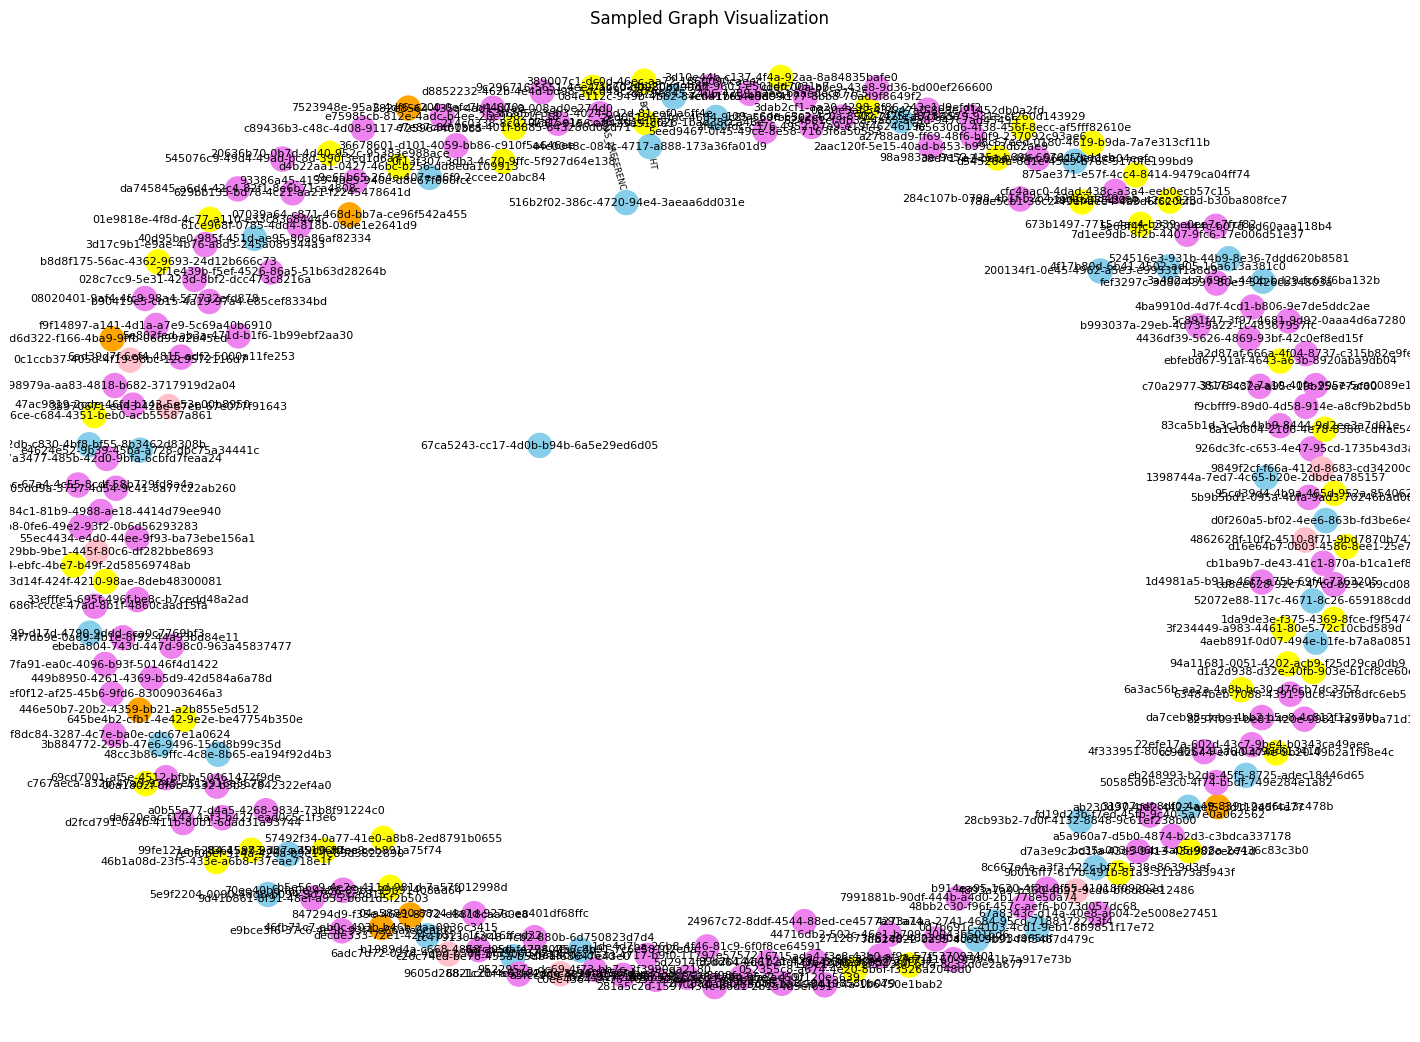

In [24]:
import random
import pandas as pd
import networkx as nx
from faker import Faker
import matplotlib.pyplot as plt

# -------------------------
# Configuration - Scale Up for a Robust RAG System
# -------------------------
NUM_CITIES = 100
NUM_HOTELS = 2000
NUM_RESTAURANTS = 2000
NUM_USERS = 10000
NUM_FLIGHTS = 10000

fake = Faker()

# -------------------------
# Data Generation Functions
# -------------------------
def generate_cities(num=NUM_CITIES):
    cities = []
    for _ in range(num):
        cities.append({
            'city_id': fake.uuid4(),
            'city_name': fake.city()
        })
    return pd.DataFrame(cities)

def generate_hotels(cities_df, num=NUM_HOTELS):
    hotels = []
    city_ids = cities_df['city_id'].tolist()
    # Ensure each city has at least one hotel
    for cid in city_ids:
        hotels.append({
            'hotel_id': fake.uuid4(),
            'hotel_name': fake.company(),
            'city_id': cid
        })
    # Add extra random hotels to reach desired count
    for _ in range(num - len(city_ids)):
        cid = random.choice(city_ids)
        hotels.append({
            'hotel_id': fake.uuid4(),
            'hotel_name': fake.company(),
            'city_id': cid
        })
    return pd.DataFrame(hotels)

def generate_restaurants(cities_df, num=NUM_RESTAURANTS):
    restaurants = []
    city_ids = cities_df['city_id'].tolist()
    # Ensure each city has at least one restaurant
    for cid in city_ids:
        restaurants.append({
            'restaurant_id': fake.uuid4(),
            'restaurant_name': fake.company(),
            'city_id': cid
        })
    # Add extra random restaurants to reach desired count
    for _ in range(num - len(city_ids)):
        cid = random.choice(city_ids)
        restaurants.append({
            'restaurant_id': fake.uuid4(),
            'restaurant_name': fake.company(),
            'city_id': cid
        })
    return pd.DataFrame(restaurants)

def generate_users(cities_df, num=NUM_USERS):
    users = []
    city_ids = cities_df['city_id'].tolist()
    for _ in range(num):
        visited = random.choice(city_ids)
        # "wants_to_visit" may be different from the visited city
        wants = random.choice(city_ids)
        users.append({
            'user_id': fake.uuid4(),
            'name': fake.name(),
            'visited_city_id': visited,
            'wants_to_visit_city_id': wants
        })
    return pd.DataFrame(users)

def generate_flights(users_df, cities_df, num=NUM_FLIGHTS):
    flights = []
    user_ids = users_df['user_id'].tolist()
    city_ids = cities_df['city_id'].tolist()
    for _ in range(num):
        flights.append({
            'flight_id': fake.uuid4(),
            'user_id': random.choice(user_ids),
            'city_id': random.choice(city_ids)  # destination city
        })
    return pd.DataFrame(flights)

def generate_preferences(users_df):
    preferences = []
    for _, user in users_df.iterrows():
        num_prefs = random.randint(1, 3)
        for _ in range(num_prefs):
            preferences.append({
                'preference_id': fake.uuid4(),
                'user_id': user['user_id'],
                'preference_detail': fake.word()
            })
    return pd.DataFrame(preferences)

# -------------------------
# Graph Building with NetworkX
# -------------------------
def build_graph(cities_df, hotels_df, restaurants_df, users_df, flights_df, prefs_df):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes with attributes (node type, name, etc.)
    # Cities
    for _, row in cities_df.iterrows():
        G.add_node(row['city_id'], label="City", name=row['city_name'])
    
    # Hotels
    for _, row in hotels_df.iterrows():
        G.add_node(row['hotel_id'], label="Hotel", name=row['hotel_name'], city_id=row['city_id'])
    
    # Restaurants
    for _, row in restaurants_df.iterrows():
        G.add_node(row['restaurant_id'], label="Restaurant", name=row['restaurant_name'], city_id=row['city_id'])
    
    # Users
    for _, row in users_df.iterrows():
        G.add_node(row['user_id'], label="User", name=row['name'], 
                   visited_city_id=row['visited_city_id'], 
                   wants_to_visit_city_id=row['wants_to_visit_city_id'])
    
    # Flights
    for _, row in flights_df.iterrows():
        G.add_node(row['flight_id'], label="Flight", user_id=row['user_id'], city_id=row['city_id'])
    
    # Preferences
    for _, row in prefs_df.iterrows():
        G.add_node(row['preference_id'], label="Preference", 
                   preference_detail=row['preference_detail'], user_id=row['user_id'])
    
    # -------------------------
    # Create Relationships (Edges)
    # -------------------------
    # User BOOKED_FLIGHT Flight
    for _, row in flights_df.iterrows():
        user_id = row['user_id']
        flight_id = row['flight_id']
        if user_id in G and flight_id in G:
            G.add_edge(user_id, flight_id, relationship="BOOKED_FLIGHT")
    
    # Flight HAS_FLIGHT City (destination)
    for _, row in flights_df.iterrows():
        flight_id = row['flight_id']
        city_id = row['city_id']
        if flight_id in G and city_id in G:
            G.add_edge(flight_id, city_id, relationship="HAS_FLIGHT")
    
    # User VISITED City (using visited_city_id from users)
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        visited_city = row['visited_city_id']
        if user_id in G and visited_city in G:
            G.add_edge(user_id, visited_city, relationship="VISITED")
    
    # User WANTS_TO_VISIT City (using wants_to_visit_city_id)
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        want_city = row['wants_to_visit_city_id']
        if user_id in G and want_city in G:
            G.add_edge(user_id, want_city, relationship="WANTS_TO_VISIT")
    
    # Build lookup dictionaries for hotels and restaurants by city
    hotels_by_city = hotels_df.groupby("city_id")["hotel_id"].apply(list).to_dict()
    restaurants_by_city = restaurants_df.groupby("city_id")["restaurant_id"].apply(list).to_dict()
    
    # User STAYED_AT Hotel and DINED_AT Restaurant (based on visited city)
    for _, row in users_df.iterrows():
        user_id = row['user_id']
        visited_city = row['visited_city_id']
        if visited_city in hotels_by_city:
            hotel_id = random.choice(hotels_by_city[visited_city])
            if user_id in G and hotel_id in G:
                G.add_edge(user_id, hotel_id, relationship="STAYED_AT")
        else:
            print(f"No hotel found for user {user_id} in city {visited_city}.")
        if visited_city in restaurants_by_city:
            restaurant_id = random.choice(restaurants_by_city[visited_city])
            if user_id in G and restaurant_id in G:
                G.add_edge(user_id, restaurant_id, relationship="DINED_AT")
        else:
            print(f"No restaurant found for user {user_id} in city {visited_city}.")
    
    # User HAS_PREFERENCE Preference
    for _, row in prefs_df.iterrows():
        user_id = row['user_id']
        pref_id = row['preference_id']
        if user_id in G and pref_id in G:
            G.add_edge(user_id, pref_id, relationship="HAS_PREFERENCE")
    
    return G

# -------------------------
# Graph Visualization
# -------------------------
def visualize_graph(G, sample_size=200):
    """
    Visualize a subgraph by sampling a subset of nodes.
    """
    # If the graph is very large, sample a subset of nodes.
    if len(G) > sample_size:
        sampled_nodes = random.sample(list(G.nodes), sample_size)
        subgraph = G.subgraph(sampled_nodes)
    else:
        subgraph = G
    
    # Compute layout - spring layout is usually good for visualization.
    pos = nx.spring_layout(subgraph, seed=42)
    
    # Draw nodes with color based on their label attribute.
    node_colors = []
    for node in subgraph.nodes(data=True):
        label = node[1].get("label", "")
        if label == "User":
            node_colors.append("skyblue")
        elif label == "City":
            node_colors.append("lightgreen")
        elif label == "Hotel":
            node_colors.append("orange")
        elif label == "Restaurant":
            node_colors.append("pink")
        elif label == "Flight":
            node_colors.append("yellow")
        elif label == "Preference":
            node_colors.append("violet")
        else:
            node_colors.append("gray")
    
    plt.figure(figsize=(14, 10))
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=8, edge_color="gray", arrowsize=10)
    
    # Optionally, draw edge labels (relationship types)
    edge_labels = nx.get_edge_attributes(subgraph, "relationship")
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title("Sampled Graph Visualization")
    plt.show()

# -------------------------
# Main Execution
# -------------------------
def main():
    print("Generating synthetic data...")
    cities_df = generate_cities()
    hotels_df = generate_hotels(cities_df)
    restaurants_df = generate_restaurants(cities_df)
    users_df = generate_users(cities_df)
    flights_df = generate_flights(users_df, cities_df)
    prefs_df = generate_preferences(users_df)
    
    print("Building in-memory graph using NetworkX...")
    G = build_graph(cities_df, hotels_df, restaurants_df, users_df, flights_df, prefs_df)
    
    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    # Visualize a sampled subgraph
    visualize_graph(G, sample_size=200)

if __name__ == "__main__":
    main()



